In [1]:
%%capture
# move to src folder so we can import code
%cd ../src

In [2]:
import config
# This import * is an extremely bad practice in modern Python programming. This shouldn’t be done in production
from fastai.vision.all import *

## Load data

In [3]:
help(untar_data)

Help on function untar_data in module fastai.data.external:

untar_data(url: 'str', archive: 'Path' = None, data: 'Path' = None, c_key: 'str' = 'data', force_download: 'bool' = False, base: 'str' = '~/.fastai') -> 'Path'
    Download `url` using `FastDownload.get`



In [4]:
set_seed(config.SEED)

In [5]:
path = untar_data(URLs.MNIST)

In [6]:
path.ls()

(#2) [Path('/home/jcarnero/.fastai/data/mnist_png/training'),Path('/home/jcarnero/.fastai/data/mnist_png/testing')]

In [7]:
items = get_image_files(path)
items[:10]

(#10) [Path('/home/jcarnero/.fastai/data/mnist_png/training/8/37979.png'),Path('/home/jcarnero/.fastai/data/mnist_png/training/8/7450.png'),Path('/home/jcarnero/.fastai/data/mnist_png/training/8/38606.png'),Path('/home/jcarnero/.fastai/data/mnist_png/training/8/44748.png'),Path('/home/jcarnero/.fastai/data/mnist_png/training/8/38863.png'),Path('/home/jcarnero/.fastai/data/mnist_png/training/8/30401.png'),Path('/home/jcarnero/.fastai/data/mnist_png/training/8/38324.png'),Path('/home/jcarnero/.fastai/data/mnist_png/training/8/47099.png'),Path('/home/jcarnero/.fastai/data/mnist_png/training/8/29886.png'),Path('/home/jcarnero/.fastai/data/mnist_png/training/8/41431.png')]

In [8]:
im = PILImageBW.create(items[0])

most of the lowest level data API's contain a `show` function

<AxesSubplot:>

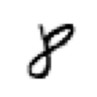

In [9]:
im.show()

## Build data loaders

In [10]:
splitter = GrandparentSplitter(
    train_name="training",
    valid_name="testing",
)

In [11]:
splits = splitter(items)
splits[0][:5], splits[1][:5]

([0, 1, 2, 3, 4], [60000, 60001, 60002, 60003, 60004])

In [12]:
len(splits[0]), len(splits[1])

(60000, 10000)

60K items in training, and 10K in validation dataset

In [13]:
dsrc = Datasets(
    items,
    tfms=[[PILImageBW.create], [parent_label, Categorize]],
    splits=splits
)

<AxesSubplot:title={'center':'8'}>

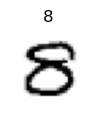

In [14]:
show_at(dsrc.train, 3)

We need to transform data into something trainable

In [15]:
item_tfms = [CropPad(34), RandomCrop(size=28), ToTensor()]

In [16]:
batch_tfms = [IntToFloatTensor(), Normalize()]

**Note** When outside the DataBlock API, item_tfms and batch_tfms will always be referenced as after_item and after_batch, including inside the dataloader itself.

In [17]:
dls = dsrc.dataloaders(
    bs=128,
    after_item=item_tfms,
    after_batch=batch_tfms
)

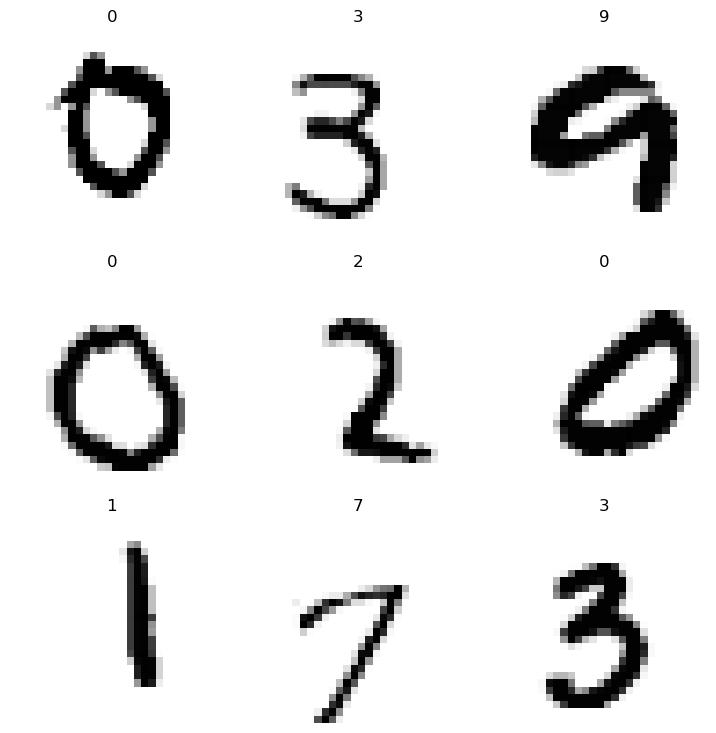

In [18]:
dls.show_batch()

Let's see the raw values of the data loader

In [19]:
dls.one_batch?

Signature: dls.one_batch()
Docstring: Return one batch from `DataLoader`.
File:      /opt/miniconda3/envs/fastai/lib/python3.10/site-packages/fastai/data/load.py
Type:      method

In [20]:
xb, yb = dls.one_batch()

In [21]:
xb.shape, yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [22]:
dls.c  # number of classes in output

10

In [23]:
dls.vocab

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

## Building a model

We won't use a pretrained model, as mnist doesn't resembles to imagenet

In [24]:
model = resnet18(num_classes=dls.c).cuda()
model.fc

Linear(in_features=512, out_features=10, bias=True)

In [25]:
model(xb)

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[128, 1, 28, 28] to have 3 channels, but got 1 channels instead

In [26]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
model.conv1

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [28]:
model.conv1 = nn.Conv2d(
    in_channels=1, 
    out_channels=64, 
    kernel_size=(7,7), 
    stride=(2,2), 
    padding=(3,3), 
    bias=False
)

In [29]:
model.cuda()
model(xb)

TensorImageBW([[-0.3118, -0.7454, -0.4254,  ..., -0.0918,  0.6093, -1.0317],
               [ 0.5081, -1.2288,  0.6555,  ..., -1.1132,  0.5085, -0.5694],
               [ 0.0565, -0.8466, -0.2741,  ...,  1.4431,  0.9553,  0.4734],
               ...,
               [-0.1597, -0.9514,  0.4706,  ...,  0.1244,  0.5852,  1.3762],
               [-0.3457,  1.0447, -0.5959,  ..., -0.7422, -0.4730,  0.1136],
               [ 0.0655,  0.0692, -0.2027,  ...,  0.0111, -0.2506, -0.3353]],
              device='cuda:0', grad_fn=<AliasBackward0>)

In [30]:
learn = Learner(dls, model, metrics=[accuracy])

In [31]:
learn.fit(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.112710,0.067409,0.979900,00:16


## Low-level prediction

In [32]:
preds = learn.predict(items[0]); preds

('8',
 tensor(8),
 tensor([2.9165e-07, 1.7517e-06, 2.0646e-05, 4.3003e-04, 3.0212e-07, 8.1722e-06,
         8.7730e-06, 1.1124e-06, 9.9952e-01, 8.3208e-06]))

The same can be done by

In [33]:
dl = learn.dls.test_dl(items[:1])
inps, preds, _, decoded_preds = learn.get_preds(dl=dl, with_decoded=True, with_input=True)
image, class_prediction = learn.dls.decode_batch((inps,) + tuplify(decoded_preds))[0]

In [34]:
class_prediction, decoded_preds

('8', tensor([8]))

And even more low level

In [35]:
learn.dls.after_item, learn.dls.after_batch

(Pipeline: CropPad -- {'size': (34, 34), 'pad_mode': 'zeros'} -> RandomCrop -- {'size': (28, 28), 'p': 1.0} -> ToTensor,
 Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Normalize -- {'mean': None, 'std': None, 'axes': (0, 2, 3)})

In [36]:
learn.dls.after_batch[1].mean, learn.dls.after_batch[1].std

(TensorImageBW([[[[0.1321]]]], device='cuda:0'),
 TensorImageBW([[[[0.3088]]]], device='cuda:0'))

In [37]:
type_tfms = Pipeline([PILImageBW.create])
item_tfms = Pipeline([CropPad((34,34)), RandomCrop((28,28)), ToTensor()])
batch_tfms = Pipeline([
    IntToFloatTensor(), 
    Normalize.from_stats([[[[0.1321]]]], [[[[0.3088]]]])
])

In [38]:
im = type_tfms(items[0]); im.shape

(28, 28)

In [39]:
item_tfms(im).shape

torch.Size([1, 28, 28])

In [40]:
batch_tfms(item_tfms(im).cuda()).shape

torch.Size([1, 1, 28, 28])

In [41]:
net = learn.model
net.eval()
t_im = batch_tfms(item_tfms(im).cuda())

In [42]:
with torch.no_grad():
    out = net(t_im)

In [43]:
out.argmax(dim=-1)

TensorImageBW([8], device='cuda:0')

In [44]:
out.softmax(-1)

TensorImageBW([[2.7514e-07, 1.6450e-06, 1.9516e-05, 4.0808e-04, 2.8472e-07,
                7.7130e-06, 8.4236e-06, 1.0461e-06, 9.9955e-01, 7.8975e-06]],
              device='cuda:0')